In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.stats.api as sms
from scipy import stats
import statsmodels.api as sm

(237, 6) (237, 6) (237, 6) (237, 6)


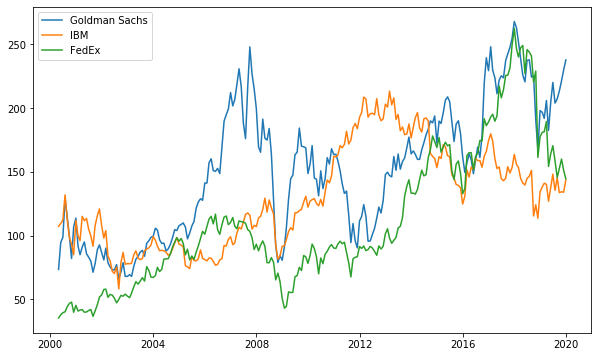

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data_gs = pd.read_csv('GS.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data_sp500 = pd.read_csv('^GSPC.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data_ibm = pd.read_csv('IBM.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data_fdx = pd.read_csv('FDX.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
print(data_sp500.shape, data_gs.shape, data_ibm.shape, data_fdx.shape)

plt.figure(figsize=(10, 6))
plt.plot(data_gs['Close'], label='Goldman Sachs')
#plt.plot(data_sp500['x'], label='')
plt.plot(data_ibm['Close'], label='IBM')
plt.plot(data_fdx['Close'], label='FedEx')
plt.legend();

In [3]:
def model_parameters(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    lin = model.fit()
    return lin

# Linear Regression

In [4]:
model = model_parameters(data_sp500['Close'].values, data_gs['Close'].values)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     358.9
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           3.28e-49
Time:                        16:29:21   Log-Likelihood:                -1160.6
No. Observations:                 237   AIC:                             2325.
Df Residuals:                     235   BIC:                             2332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.8674      5.958      7.530      0.000      33.129      56.606
x1             0.0665      0.004     18.944      0.000       0.060       0.073
==============================================================================
Omnibus:                       15.966   Durbin-Watson:                   0.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.435
Skew:                           0.642   Prob(JB):                     0.000164
Kurtosis:                       2.656   Cond. No.                     4.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

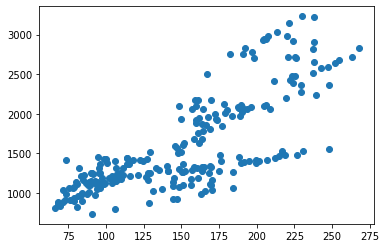

In [5]:
plt.scatter(data_gs['Close'].values, data_sp500['Close'].values);

# Heteroscedasticity test

### Hypothesis testing 
$H_0: \epsilon_{i} - homoscedastic $ <br>
$H_1: \epsilon_{i} - heteroscedastic$ <br>
From the test below we can see that obtained F equals to 5.07 and F_critical of 5.08. As obtained F-statistic is lower than F-critical therefore we can't reject H0 hypothesis. Therefore, the $\epsilon_{i}$ is most probably heteroscedastic.

In [6]:
heteroscedasticity = sms.het_goldfeldquandt(y = model.resid, x = model.model.exog)
print(f'F-statistic: {heteroscedasticity[0]}; p-value: {np.round(heteroscedasticity[1], 4)}')

F-statistic: 0.4457102838858326; p-value: 1.0


We can conclude that model is heteroscedastic as our p-value is less than 0.05, reject null hypothesis. Therefore we will apply one of the following transformations:
- $\sigma_{\epsilon_{i}}^2 = k^2 x^2$ ; $k^2 = \frac{\sigma_{\epsilon_{i}}^2}{x^2}$ 
- $\sigma_{\epsilon_{i}}^2 = k^2 x$ ; $k^2 = \frac{\sigma_{\epsilon_{i}}^2}{x}$ 

In [7]:
# method 1
X = sm.add_constant(data_sp500['Close'].values ** (-1/2))
model = sm.OLS(data_gs['Close'].values / data_sp500['Close'].values ** (-1/2), X)
model = model.fit()
print('Method 1:')
print(f'intercept: {model.params[0]}') 
print(f'coef: {model.params[1]}')
print('=='*15)
heteroscedasticity = sms.het_goldfeldquandt(y = model.resid, x = model.model.exog)
print(f'F-statistic: {heteroscedasticity[0]}; p-value: {np.round(heteroscedasticity[1], 4)}')

Method 1:
intercept: 22764.694269686213
coef: -629999.7404285857
F-statistic: 0.8002108093346199; p-value: 0.8846


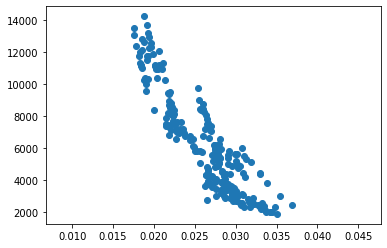

In [8]:
plt.scatter(data_sp500['Close'].values ** (-1/2), data_gs['Close'].values / data_sp500['Close'].values ** (-1/2));

In [9]:
# method 2
X = sm.add_constant(1 / data_sp500['Close'].values)
model = sm.OLS(data_gs['Close'].values / data_sp500['Close'].values, X)
model = model.fit()
print('Method 1:')
print(f'intercept: {model.params[0]}') 
print(f'coef: {model.params[1]}')
print('=='*15)
heteroscedasticity = sms.het_goldfeldquandt(y = model.resid, x = model.model.exog)
print(f'F-statistic: {heteroscedasticity[0]}; p-value: {np.round(heteroscedasticity[1], 4)}')

Method 1:
intercept: 0.0776880297059292
coef: 28.206514179759488
F-statistic: 0.21534486343655151; p-value: 1.0


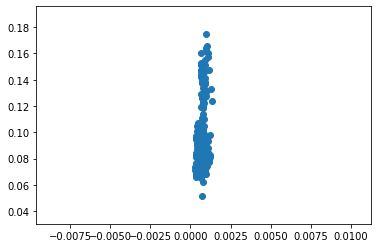

In [10]:
plt.scatter(1 / data_sp500['Close'].values, data_gs['Close'].values / data_sp500['Close'].values);

As we can see both methods solve our issue with heteroskedasticity. Even though the first method has a higher F value. I would choose method 2 solution as it transforms the data almost in a linear way.

# Multicollinearity

In [11]:
model = model_parameters(np.stack([data_gs['Close'].values, data_fdx['Close'].values, data_ibm['Close'].values]).T, data_sp500['Close'].values)
preds = model.predict(np.stack([np.ones(data_gs['Close'].shape[0]), data_gs['Close'].values, data_fdx['Close'].values, data_ibm['Close'].values]).T)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     312.4
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           2.39e-81
Time:                        16:29:22   Log-Likelihood:                -1662.0
No. Observations:                 237   AIC:                             3332.
Df Residuals:                     233   BIC:                             3346.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        287.3533     72.159      3.982      0.000     145.186     429.521
x1             1.4034      0.613      2.290      0.023       0.196       2.611
x2             8.4054      0.598     14.061      0.000       7.228       9.583
x3             1.2003      0.508      2.361      0.019       0.199       2.202
==============================================================================
Omnibus:                      123.275   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              485.741
Skew:                           2.237   Prob(JB):                    3.33e-106
Kurtosis:                       8.401   Cond. No.                         977.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
print('Multi-Factor Model')
print('Parameters: \nb_0: {} b_1: {} b_2: {}, b_3: {}'.format(model.params[0], model.params[1], model.params[2], model.params[3]))
print('===============================================' * 2)
print(f'R_squared: {np.round(model.rsquared, 3)}   r:{np.round(np.sqrt(model.rsquared), 3)}  F-statistic: {np.round(model.fvalue, 3)}')

Multi-Factor Model
Parameters: 
b_0: 287.3533315563685 b_1: 1.4033939710001648 b_2: 8.405418057617965, b_3: 1.2003342725488286
R_squared: 0.801   r:0.895  F-statistic: 312.445


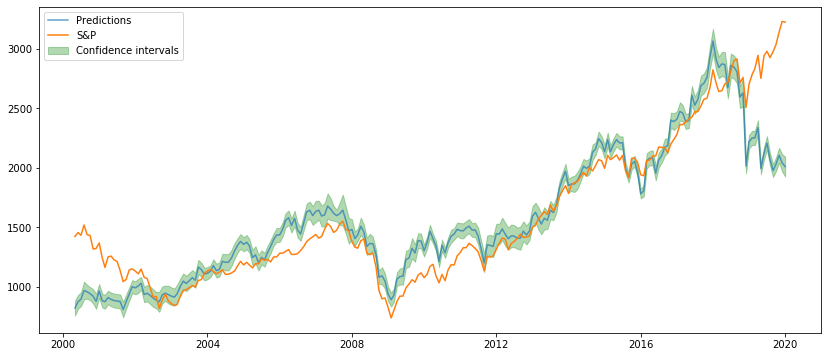

In [13]:
yprd_ci_lower, yprd_ci_upper = summary_table(model, alpha = 0.05)[1][:, 4:6].T
plt.figure(figsize=(14, 6))
plt.plot(data_sp500.index, preds, label='Predictions', alpha = 0.7)
plt.plot(data_sp500.index, data_sp500['Close'].values, label='S&P')
plt.fill_between(data_sp500.index, yprd_ci_lower, yprd_ci_upper, color='green', label='Confidence intervals', alpha=0.3)
plt.legend();

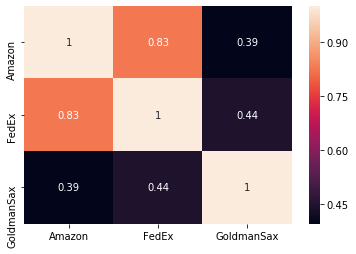

In [14]:
t = pd.DataFrame(np.stack([data_gs['Close'].values, data_fdx['Close'].values, data_ibm['Close'].values]).T, columns=['Amazon','FedEx','GoldmanSax'])
sns.heatmap(t.corr(), annot=True);

In [15]:
cc = np.corrcoef(t, rowvar=False)
VIF = np.linalg.inv(cc)
VIF.diagonal()

array([3.21620437, 3.38029901, 1.24848733])

As we can see our values are less than 10 [(Variance inflation)](https://en.wikipedia.org/wiki/Variance_inflation_factor) we can't conclude that there is high multicollinearity. Therefore we will not change the model